# Assignment 2 Xi Peng
## Develop RAW images

In [11]:
import glob
import os
import subprocess
import cv2
import numpy as np


In [ ]:
# Get files with .NEF
raw_files = glob.glob(os.path.join("data", "door_stack", "door_stack", "*.nef"))
# print(raw_files)

# loop row and do the dcraw
for file in raw_files:
    command = f"dcraw -v -w -q 3 -o 1 -4 -T \"{file}\""
    print("In processing:", file)
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

In processing: data/door_stack/door_stack/exposure9.nef
In processing: data/door_stack/door_stack/exposure8.nef
In processing: data/door_stack/door_stack/exposure13.nef
In processing: data/door_stack/door_stack/exposure12.nef
In processing: data/door_stack/door_stack/exposure10.nef
In processing: data/door_stack/door_stack/exposure11.nef
In processing: data/door_stack/door_stack/exposure15.nef
In processing: data/door_stack/door_stack/exposure14.nef
In processing: data/door_stack/door_stack/exposure16.nef
In processing: data/door_stack/door_stack/exposure1.nef
In processing: data/door_stack/door_stack/exposure3.nef
In processing: data/door_stack/door_stack/exposure2.nef
In processing: data/door_stack/door_stack/exposure6.nef
In processing: data/door_stack/door_stack/exposure7.nef
In processing: data/door_stack/door_stack/exposure5.nef
In processing: data/door_stack/door_stack/exposure4.nef


## Linearization

In [ ]:

from imageio.v2 import imread
# Get files with .jpg
jpg_files = []
for i in range(1, 17):
    jpg_files.append(os.path.join("data", "door_stack", 
                                  "door_stack", f"exposure{i}.jpg"))
num_images = len(jpg_files)
H, W= cv2.imread(str(jpg_files[0]), cv2.IMREAD_UNCHANGED).shape[:2]
print(jpg_files)
print("Number of images:", num_images)
print("Image size:", H, W)

['data/door_stack/door_stack/exposure1.jpg', 'data/door_stack/door_stack/exposure2.jpg', 'data/door_stack/door_stack/exposure3.jpg', 'data/door_stack/door_stack/exposure4.jpg', 'data/door_stack/door_stack/exposure5.jpg', 'data/door_stack/door_stack/exposure6.jpg', 'data/door_stack/door_stack/exposure7.jpg', 'data/door_stack/door_stack/exposure8.jpg', 'data/door_stack/door_stack/exposure9.jpg', 'data/door_stack/door_stack/exposure10.jpg', 'data/door_stack/door_stack/exposure11.jpg', 'data/door_stack/door_stack/exposure12.jpg', 'data/door_stack/door_stack/exposure13.jpg', 'data/door_stack/door_stack/exposure14.jpg', 'data/door_stack/door_stack/exposure15.jpg', 'data/door_stack/door_stack/exposure16.jpg']
Number of images: 16
Image size: 4000 6000


In [190]:
selected_index = np.random.permutation(H*W)[:200].tolist()
channel = 3
selected_pixels = [
    imread(p)
    .reshape(-1, channel)[selected_index]
    .flatten() for p in jpg_files
]
selected_pixels = np.stack(selected_pixels, axis=0).transpose()
print("Selected pixels shape:", selected_pixels.shape)

Selected pixels shape: (600, 16)


In [191]:
exposure_times = np.arange(1, num_images + 1)
exposure_times = 2 ** (exposure_times - 1)/2048
print("Exposure times:", exposure_times)

Exposure times: [4.8828125e-04 9.7656250e-04 1.9531250e-03 3.9062500e-03 7.8125000e-03
 1.5625000e-02 3.1250000e-02 6.2500000e-02 1.2500000e-01 2.5000000e-01
 5.0000000e-01 1.0000000e+00 2.0000000e+00 4.0000000e+00 8.0000000e+00
 1.6000000e+01]


In [204]:
from typing import Callable
z_min = 0.05
z_max = 0.95
def w_uniform(z, *_):
    return np.where((z >= z_min) & (z <= z_max), 1, 0)

def w_tent(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.minimum(z, 1 - z), 0)

def w_gaussian(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.exp(-4 * (z - 0.5)**2 / (0.5**2)), 0)

def w_photon(z, t):
    return np.where((z >= z_min) & (z <= z_max), t, 0)

w_functions = {
    'uniform': w_uniform,
    'tent': w_tent,
    'gaussian': w_gaussian,
    'photon': w_photon
}

def gsolve(Z, B, l, weighting_function: Callable):
    Z = Z.astype(np.int64)
    n = 256
    num_pixels, num_images = Z.shape
    A_rows = num_pixels * num_images + n+1
    A_cols = n + num_pixels

    # 初始化线性方程组 A * x = b
    A = np.zeros((A_rows, A_cols), dtype=np.float32)
    b = np.zeros((A_rows,), dtype=np.float32)

    k = 0
    # 对每个像素位置和每张图片构建方程
    for i in range(num_pixels):
        for j in range(num_images):
            z_ij = Z[i, j]
            # 利用 numpy 计算权重:
            # 将 z_ij 归一化到 [0, 1]，同时 B[j] 取指数（对应 torch.exp(B[j])）
            wij = weighting_function(z_ij / 255.0, np.exp(B[j]))
            A[k, z_ij] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # # 固定曝光曲线：将中间值设为 0
    A[k, 128] = 1
    k += 1

    # 构建平滑性约束方程
    for i in range(0, n - 2):
        # 如果 weighting_function 不是 w_photon，则计算平滑性对应的权重；
        # 否则直接使用 1（这里假设 w_photon 也已用 numpy 重写）
        if weighting_function != w_photon:
            w_i = weighting_function((i+1) / 255.0, None)
        else:
            w_i = 1
        A[k, i]     = l * w_i
        A[k, i + 1] = -2 * l * w_i
        A[k, i + 2] = l * w_i
        k += 1

    # 利用 numpy 的最小二乘法求解线性系统 A * x = b
    # np.linalg.lstsq 返回 (solution, residuals, rank, singular_values)
    print(f"Solving system of size A: {A.shape}, b: {b.shape}")
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    # x 的前 n 个元素为 g，后面为每个像素的对数辐照度 lE
    g = x[:n]
    lE = x[n:]

    return g, lE

Solving system of size A: (9857, 856), b: (9857,)
(256,) (600,)


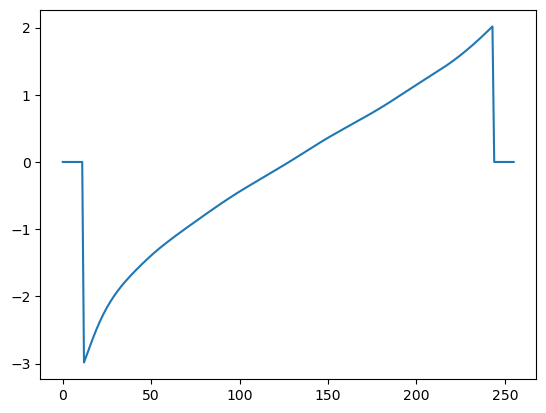

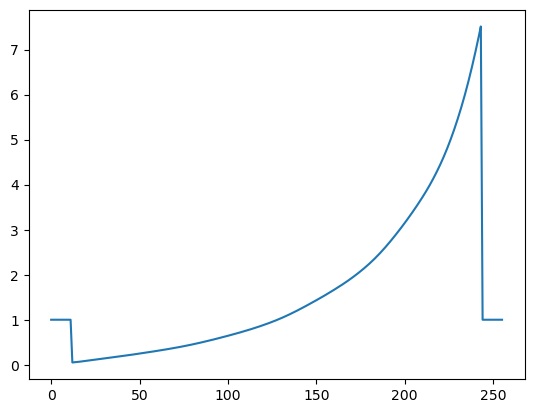

In [205]:

import matplotlib.pyplot as plt
method = 'tent'
lamb = 100

g, lE = gsolve(selected_pixels, np.log(exposure_times), lamb, w_functions[method])
print(g.shape, lE.shape)

plt.plot(range(256), g)
plt.show()
plt.plot(range(256), np.exp(g))
plt.show()

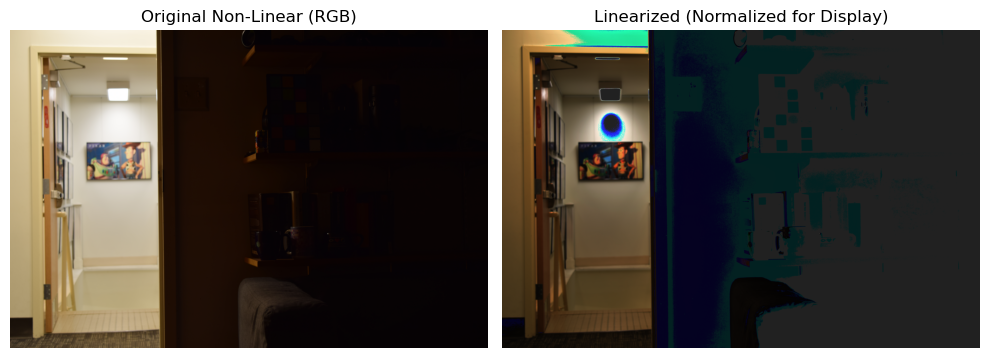

In [206]:
def convert_to_linear_image_rgb(img_nonlin: np.ndarray, g: np.ndarray, norm=False) -> np.ndarray:
    img_nonlin = np.clip(img_nonlin, 0, 255).astype(np.uint16)
    H, W, C = img_nonlin.shape
    img_lin = np.zeros((H, W, C), dtype=np.float32)
    for c in range(C):
        img_lin[..., c] = np.exp(g[img_nonlin[..., c]])
        if norm:
            img_lin[..., c] = img_lin[..., c] / np.max(img_lin[..., c])
    return img_lin

img_test = imread(os.path.join("data", "door_stack", 
                                  "door_stack", "exposure10.jpg"))



img_lin = convert_to_linear_image_rgb(img_test, g, norm=True)

# img_lin_norm = img_lin / np.max(img_lin)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original Non-Linear (RGB)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_lin)
plt.title("Linearized (Normalized for Display)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [210]:
import numpy as np
from imageio.v2 import imread
jpg_files = []
tiff_files = []
for i in range(1, 17):
    jpg_files.append(os.path.join("data", "door_stack", 
                                  "door_stack", f"exposure{i}.jpg"))
    tiff_files.append(os.path.join("data", "door_stack",
                                "door_stack", f"exposure{i}.tiff"))
print(jpg_files)
print(tiff_files)

tiff_images = np.array([imread(f).astype(np.float32) / (2**16  -1)  for f in tiff_files])
print(tiff_images.shape)


jpg_images_ldr = np.array([imread(f).astype(np.float32)/ (2**8  -1) for f in jpg_files])
print(jpg_images_ldr.shape)
print(jpg_images_ldr.max(), jpg_images_ldr.min())
jpg_images_lin = np.array([convert_to_linear_image_rgb(imread(f), g).astype(np.float32) for f in jpg_files])
print(jpg_images_lin.shape)

def merge_hdr(images_ldr, images_lin, times, w_func):
    """
    根据给定的公式将 k 张 LDR/线性图像合成为一张 HDR 图像。

    参数：
    ----------
    images_ldr : numpy.ndarray
        形状 (k, H, W, 3)，存放 k 张 LDR 图像，像素值范围 [0,1]。
    images_lin : numpy.ndarray
        形状 (k, H, W, 3)，存放 k 张与 LDR 对应的线性图像。
    times : numpy.ndarray
        形状 (k, )，每张图像的曝光时间。
    w_func : function
        一个权重函数，输入和输出都是 [0,1] 范围的浮点数或数组。

    返回：
    ----------
    hdr_image : numpy.ndarray
        形状 (H, W, 3)，合成后的 HDR 图像。
    """
    # 计算每张 LDR 图像对应的权重 w(I^k_ij_LDR)
    # 这里 w_values 的形状为 (k, H, W, 3)
    w_values = w_func(images_ldr)

    # 先计算分子：sum_k [ w * (I_lin / t) ]
    # times[:, None, None, None] 会将 times 的形状从 (k,) 扩展为 (k, 1, 1, 1)
    numerator = np.sum(
        w_values * (images_lin / times[:, None, None, None]),
        axis=0  # 在 k 维度上求和
    )

    # 再计算分母：sum_k [ w ]
    denominator = np.sum(w_values, axis=0)

    # 计算最终的 HDR 图像
    # 使用 np.divide 并指定 where，以避免除零问题
    hdr_image = np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0))

    return hdr_image

def log_merge_hdr(images_ldr, images_lin, times, w_func):

    w_values = w_func(images_ldr)

    # 先计算分子：sum_k [ w * (I_lin / t) ]
    # times[:, None, None, None] 会将 times 的形状从 (k,) 扩展为 (k, 1, 1, 1)
    numerator = np.sum(
        w_values * (np.log(images_lin + 1e-10) - np.log(times[:, None, None, None])),
        axis=0  # 在 k 维度上求和
    )

    # 再计算分母：sum_k [ w ]
    denominator = np.sum(w_values, axis=0)

    # 计算最终的 HDR 图像
    # 使用 np.divide 并指定 where，以避免除零问题
    hdr_image = np.exp(np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0)))

    return hdr_image

hdr_result_tiff = merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
hdr_result_jpg = merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)
# # print("HDR 图像形状:", hdr_result_tiff.shape)


log_hdr_result_tiff = log_merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
log_hdr_result_jpg = log_merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)


def writeHDR(name, data):
    #flip from rgb to bgr for cv2
    cv2.imwrite(name, data[:, :, ::-1].astype(np.float32))

writeHDR("door_stack_tiff_hdr.hdr", hdr_result_tiff)
writeHDR("door_stack_jpg_hdr.hdr", hdr_result_jpg)

writeHDR("door_stack_tiff_log_hdr.hdr", log_hdr_result_tiff)
writeHDR("door_stack_jpg_log_hdr.hdr", log_hdr_result_jpg)

['data/door_stack/door_stack/exposure1.jpg', 'data/door_stack/door_stack/exposure2.jpg', 'data/door_stack/door_stack/exposure3.jpg', 'data/door_stack/door_stack/exposure4.jpg', 'data/door_stack/door_stack/exposure5.jpg', 'data/door_stack/door_stack/exposure6.jpg', 'data/door_stack/door_stack/exposure7.jpg', 'data/door_stack/door_stack/exposure8.jpg', 'data/door_stack/door_stack/exposure9.jpg', 'data/door_stack/door_stack/exposure10.jpg', 'data/door_stack/door_stack/exposure11.jpg', 'data/door_stack/door_stack/exposure12.jpg', 'data/door_stack/door_stack/exposure13.jpg', 'data/door_stack/door_stack/exposure14.jpg', 'data/door_stack/door_stack/exposure15.jpg', 'data/door_stack/door_stack/exposure16.jpg']
['data/door_stack/door_stack/exposure1.tiff', 'data/door_stack/door_stack/exposure2.tiff', 'data/door_stack/door_stack/exposure3.tiff', 'data/door_stack/door_stack/exposure4.tiff', 'data/door_stack/door_stack/exposure5.tiff', 'data/door_stack/door_stack/exposure6.tiff', 'data/door_stack/